In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from acquire import wrangle_zillow
from prepare import prep_zillow
from prepare import remove_outliers
from prepare import tts_con

import sklearn.preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression

## Acquire the data and prep it for modeling

In [2]:
#acquire the raw data
zillow=wrangle_zillow()

In [3]:
#prepare the data
zillow=prep_zillow(zillow)

In [4]:
#remove outliers
zillow, fences=remove_outliers(zillow)

In [5]:
#getting dummies for modeling
zillow = pd.get_dummies(zillow, columns=['bed_count', 'bath_count'])

In [6]:
zillow.head()

,property_value,finished_sq_ft,bed_count_2.0,bed_count_3.0,bed_count_4.0,bed_count_5.0,bath_count_1.0,bath_count_1.5,bath_count_2.0,bath_count_2.5,bath_count_3.0,bath_count_3.5,bath_count_4.0,bath_count_4.5
1,106406.0,2519.0,0,0,1,0,0,0,0,0,1,0,0,0
2,369853.0,1285.0,0,1,0,0,0,0,1,0,0,0,0,0
3,65848.0,1254.0,0,1,0,0,1,0,0,0,0,0,0,0
4,89362.0,1988.0,0,1,0,0,0,0,1,0,0,0,0,0
5,885381.0,2851.0,0,1,0,0,0,0,0,0,1,0,0,0


In [7]:
#splitting the data
m_train, m_val, m_test=tts_con(zillow)

In [8]:
#Making sure they all have the same number of features
m_train.shape, m_val.shape, m_test.shape

((26188, 14), (11224, 14), (9353, 14))

In [9]:
#splitting data into x and y sets
X_train=m_train.drop(columns=['property_value'])
y_train=m_train['property_value']

X_val=m_val.drop(columns=['property_value'])
y_val=m_val['property_value']

X_test=m_test.drop(columns=['property_value'])
y_test=m_test['property_value']

In [10]:
#create scalar
ss=sklearn.preprocessing.StandardScaler()

In [11]:
#set numeric columns and apply scalar
num_cols=['finished_sq_ft']
ss.fit(X_train[num_cols])

X_train[num_cols]= ss.transform(X_train[num_cols])
X_val[num_cols]= ss.transform(X_val[num_cols])
X_test[num_cols]= ss.transform(X_test[num_cols])

In [12]:
X_train.head()

,finished_sq_ft,bed_count_2.0,bed_count_3.0,bed_count_4.0,bed_count_5.0,bath_count_1.0,bath_count_1.5,bath_count_2.0,bath_count_2.5,bath_count_3.0,bath_count_3.5,bath_count_4.0,bath_count_4.5
32057,-0.797661,0,1,0,0,0,0,1,0,0,0,0,0
43708,-0.900668,1,0,0,0,1,0,0,0,0,0,0,0
2083,-0.680818,0,1,0,0,0,1,0,0,0,0,0,0
27554,-0.151947,0,0,1,0,0,0,1,0,0,0,0,0
45855,-0.087376,0,1,0,0,0,0,1,0,0,0,0,0


## Make models and test for error to find best performing model

### Establish baseline

In [13]:
#assigning y_train to a data frame
y_train= pd.DataFrame(y_train)
y_val=pd.DataFrame(y_val)
y_train.head()

,property_value
32057,206678.0
43708,600000.0
2083,582000.0
27554,542618.0
45855,195294.0


In [14]:
#Setting a baseline using median and mean
y_train['base_med']=y_train['property_value'].median()
y_train['base_mean']=y_train['property_value'].mean()

y_val['base_med']=y_val['property_value'].median()
y_val['base_mean']=y_val['property_value'].mean()

y_train.head()

,property_value,base_med,base_mean
32057,206678.0,344749.5,387526.101611
43708,600000.0,344749.5,387526.101611
2083,582000.0,344749.5,387526.101611
27554,542618.0,344749.5,387526.101611
45855,195294.0,344749.5,387526.101611


In [15]:
#getting rmse for each baseline to determine which one to use
med=mean_squared_error(y_train['property_value'], y_train['base_med'], squared=False)
mea=mean_squared_error(y_train['property_value'], y_train['base_mean'], squared=False)

med_v=mean_squared_error(y_val['property_value'], y_val['base_med'], squared=False)
mea_v=mean_squared_error(y_val['property_value'], y_val['base_mean'], squared=False)

print(f'Train RMSE for the median baseline is {med}')
print(f'Train RMSE for the mean baseline is {mea}')
print('\n')
print(f'Validate RMSE for the median baseline is {med_v}')
print(f'Validate RMSE for the mean baseline is {mea_v}')

Train RMSE for the median baseline is 265529.7383407816
Train RMSE for the mean baseline is 262061.4513771557


Validate RMSE for the median baseline is 268295.544925074
Validate RMSE for the mean baseline is 264235.4144336938


<div class="alert alert-info">
    <header>
    <h2>Takeaway</h2>
    </header>
    <dl>
        <dt>The RMSE for mean was lower for the baseline in both train/in sample and validate/out-of-sample data sets, so we will use mean as the baseline.</dt>
    </dl>
</div>

In [16]:
#dropping the median and keeping the mean as baseline
y_train=y_train.drop(columns=['base_med'])
y_val=y_val.drop(columns=['base_med'])

### Linear Regression (OLM)

In [17]:
#create model
lm=LinearRegression()

In [18]:
#fit the model
lm.fit(X_train, y_train['property_value'])

LinearRegression()

In [19]:
#add predictions to y train and y val
y_train['lm_preds']=lm.predict(X_train)
y_val['lm_preds']=lm.predict(X_val)

### Lasso Lars

In [20]:
#make the model
ll=LassoLars(fit_intercept=False)

In [21]:
#fit the model
ll.fit(X_train, y_train['property_value'])

/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(


LassoLars(fit_intercept=False)

In [22]:
#add predictions to y train and y val
y_train['ll_preds']=ll.predict(X_train)
y_val['ll_preds']=ll.predict(X_val)

### Tweedie Regressor (GLM)

In [23]:
#make the model
tweed=TweedieRegressor()

In [24]:
#fit the model
tweed.fit(X_train, y_train['property_value'])

TweedieRegressor()

In [25]:
#add predictions to y train and y val
y_train['tweedie_preds']=tweed.predict(X_train)
y_val['tweedie_preds']=tweed.predict(X_val)

### Polynomial Regression

In [26]:
#create new features
pf=PolynomialFeatures(degree=2)

X_train_degree2 = pf.fit_transform(X_train)
X_validate_degree2 = pf.transform(X_val)
X_test_degree2 = pf.transform(X_test)

In [27]:
#create the model
lm2= LinearRegression(normalize=True)

In [28]:
#fit the model
lm2.fit(X_train_degree2, y_train['property_value'])

/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


LinearRegression(normalize=True)

In [29]:
#make predictions
y_train['lm2_preds']=lm2.predict(X_train_degree2)
y_val['lm2_preds']=lm2.predict(X_validate_degree2)

## Calculate RMSE to find best model

In [30]:
y_train.head()

,property_value,base_mean,lm_preds,ll_preds,tweedie_preds,lm2_preds
32057,206678.0,387526.101611,284224.0,283335.645329,331093.332768,283296.0
43708,600000.0,387526.101611,299008.0,300240.310115,327276.778236,293536.0
2083,582000.0,387526.101611,295168.0,293592.506572,349252.435487,306880.0
27554,542618.0,387526.101611,320576.0,320746.388978,376757.959300,315808.0
45855,195294.0,387526.101611,367168.0,366217.742175,372896.361600,361120.0


In [31]:
#putting all models and RMSE into a dataframe for ease of viewing
preds=['base_mean', 'lm_preds', 'll_preds', 'tweedie_preds', 'lm2_preds']
a=[]
b=[]
e=[]
c=[a,b,e]

for col in y_train[preds]:
    rmse= mean_squared_error(y_train['property_value'], y_train[col], squared=False)
    rmsev=mean_squared_error(y_val['property_value'], y_val[col], squared=False)
    b.append(rmse)
    a.append(col)
    e.append(rmsev)
    rmsedf= pd.DataFrame(data=c, index=['Model', 'RMSE Train', 'RMSE Validate']).T
    rmsedf['difference']=rmsedf['RMSE Validate']-rmsedf['RMSE Train']

In [32]:
rmsedf=rmsedf.sort_values(by='difference')
rmsedf

,Model,RMSE Train,RMSE Validate,difference
1,lm_preds,226521.171742,227107.371795,586.200053
2,ll_preds,226519.17107,227114.187643,595.016573
4,lm2_preds,226173.932596,227161.743853,987.811256
3,tweedie_preds,237572.982168,238732.274473,1159.292305
0,base_mean,262061.451377,264235.414434,2173.963057


Text(0.5, 1.0, 'RMSE difference for Models')

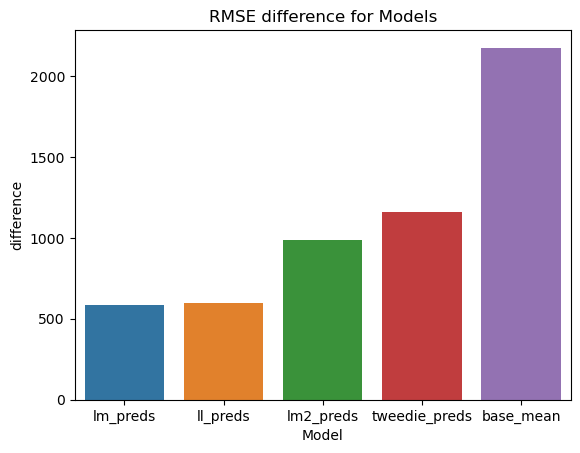

In [33]:
#visualization of RMSE
sns.barplot(x='Model', y='difference', data=rmsedf)
plt.title('RMSE difference for Models')

<div class="alert alert-info">
    <header>
    <h2>Takeaway</h2>
    </header>
    <dl>
        <dt>All models performed better than the baseline. The RMSE for polynomial regression was the lowest of all the models at 226173.93. However, the difference between the train and validate RMSE was smallest on the linear regression model and the train was very close to the polynomial regression model. Because the difference in RMSE is smaller for linear regression, I will use that model for the test set.</dt>
    </dl>
</div>

### Use test data with linear regression model

In [34]:
#making y_test into a dataframe
y_test=pd.DataFrame(y_test)

In [35]:
#make predictions
y_test['lm_preds']=lm.predict(X_test)
y_test.head()

,property_value,lm_preds
11440,437934.0,348096.0
1901,70154.0,286528.0
30354,309344.0,450816.0
47813,551322.0,360576.0
17794,74893.0,470272.0


In [36]:
test_rmse=mean_squared_error(y_test['property_value'], y_test['lm_preds'], squared=False)
test_rmse

230232.3898560135

In [42]:
final_model= pd.DataFrame(rmsedf.iloc[0,:]).T
final_model['RMSE Test']= test_rmse
final_model

,Model,RMSE Train,RMSE Validate,difference,RMSE Test
1,lm_preds,226521.171742,227107.371795,586.200053,230232.389856


### Next Step/After MVP chase this if time

In [60]:
def select_kbest(x,y, k=2):
    ss=sklearn.preprocessing.StandardScaler()
    ss.fit(x)
    X_train_scaled=ss.transform(x)
    
    f_selector=SelectKBest(f_regression, k=4)
    X_reduced=f_selector.fit_transform(X_train_scaled, y)
    f_support = f_selector.get_support()
    features=x.iloc[:,f_support]
    return features

In [61]:
select_kbest(X_train, y_train['property_value'], 4)

,finished_sq_ft,bath_count_1.0,bath_count_3.0,bath_count_4.0
32057,-0.797661,0,0,0
43708,-0.900668,1,0,0
2083,-0.680818,0,0,0
27554,-0.151947,0,0,0
45855,-0.087376,0,0,0
...,...,...,...,...
48822,1.088745,0,1,0
36510,1.362405,0,0,1
36985,0.164760,0,1,0
48943,-0.530151,0,0,0
